## Data Mining Reader Rating Prediction

### Our Team Strategy:

First, we explored and analyzed feature data. We attempted to build up **relationships** between various features and ratings via analyzing **pearson cofficients** and **sample distributions** on various dimensions.

Second, we **extended the reader feature space** based on our analysis, e.g. the variety of book genres a reader has read in 2017 and wanted to read, one hot labeling of store locations that a reader has visited.

Thrid, we built an input space based on the collected features and modeled "Average Rating (2017)" as the prediction labels. Several **machine learning** algorithms were employed.

Forth, we collected historical reader ratings on all books, by which the average rating on each book by readers now serve as the book rating. Readers in 2018 with their books to read specified, will have an estimate ratings based on **each book ratings in 2017**.

Finally, we **combined** the predictions from the machine learning models and previous year rating data to finalize the prediction.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import glob
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn import preprocessing
from xgboost import XGBClassifier


filename_list = glob.glob('all/*.csv')

df = []

for each_csv in filename_list:
    df.append(pd.read_csv(each_csv))

bookinfo_genre = 1
bookinfo_words = 3
bookinfo = 5
readerinfo = 4


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# reader sensitivity to price
num_readers = len(df[readerinfo])
df[bookinfo]['Price_mean'] = (df[bookinfo]['Price (2017)'] + df[bookinfo]['Price (2018)']) / 2
Reader_read_books = [book_2017 for book_2017 in list(df[readerinfo]['User Read Books (2017)'])]
Reader_read_books = [np.array(each_user_books.split(', ')) for each_user_books in Reader_read_books]
Reader_spent_on_books = np.zeros(num_readers)
for each_reader in df[readerinfo].index:
    bool_idx = df[bookinfo]['Book ID'].isin(Reader_read_books[each_reader])
    Reader_spent_on_books[each_reader] = df[bookinfo][bool_idx]['Price_mean'].sum()
Reader_spent_on_books = pd.DataFrame(Reader_spent_on_books, columns=['Price_sum'])
df[readerinfo] = pd.merge(df[readerinfo], Reader_spent_on_books, left_index=True, right_index=True)


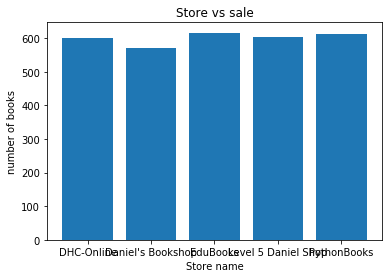

In [3]:
# plot where books are most sold
location_list = list(df[bookinfo]['Most Sold At'])
unique_locations, counts_locations = np.unique(location_list, return_counts=True)
plt.bar(unique_locations, counts_locations)
plt.title("Store vs sale")
plt.ylabel("number of books")
plt.xlabel("Store name")
plt.show()

In [4]:
# readers visited stores
reader_location_list = []
for each_reader in df[readerinfo].index:
    bool_idx = df[bookinfo]['Book ID'].isin(Reader_read_books[each_reader])
    reader_location_list.append(list(df[bookinfo][bool_idx]['Most Sold At']))
store_label_scheme = dict(zip(unique_locations, range(len(unique_locations))))
store_num_label = [list(map(lambda x: store_label_scheme[x], reader_location_list[i])) for i in range(num_readers)]
reader_visited_stores = [len(np.unique(store_num_label[i])) for i in range(num_readers)]
reader_visited_stores = np.int32(reader_visited_stores)

reader_visited_stores_one_hot = np.zeros((num_readers, len(unique_locations)))
for each_user_store_idx, each_user_store in enumerate(store_num_label):
    for each_store_idx in np.unique(each_user_store):
        reader_visited_stores_one_hot[each_user_store_idx, each_store_idx] = 1

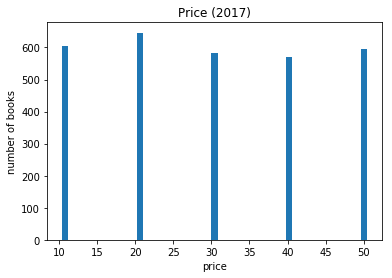

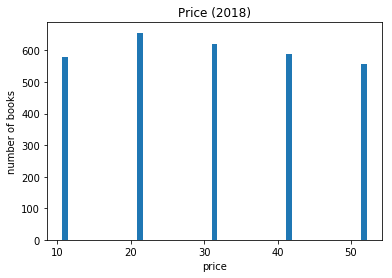

In [5]:
# plot book price range
price_brackets = 5
price2017_val = df[bookinfo]['Price (2017)'].values
price2017_max = max(price2017_val)
price2017_min = min(price2017_val)
price_range = (price2017_max - price2017_min) / price_brackets
price_up_range_list = np.array([price2017_min + price_range * (i+1) for i in range(price_brackets)])
price_down_range_list = np.array([price2017_min + price_range * i for i in range(price_brackets)])
price_hits_range_list = [np.array(price2017_val <= price_up_range_list[i]) & np.array(price2017_val >= price_down_range_list[i]) for i in range(price_brackets)]
price_hits_range_list = np.sum(np.int16(price_hits_range_list), axis=1)
plt.bar(price_up_range_list, price_hits_range_list)
plt.title("Price (2017)")
plt.xlabel("price")
plt.ylabel("number of books")
plt.show()

price_brackets = 5
price2018_val = df[bookinfo]['Price (2018)'].values
price2018_max = max(price2018_val)
price2018_min = min(price2018_val)
price_range = (price2018_max - price2018_min) / price_brackets
price_up_range_list = np.array([price2018_min + price_range * (i+1) for i in range(price_brackets)])
price_down_range_list = np.array([price2018_min + price_range * i for i in range(price_brackets)])
price_hits_range_list = [np.array(price2018_val <= price_up_range_list[i]) & np.array(price2018_val >= price_down_range_list[i]) for i in range(price_brackets)]
price_hits_range_list = np.sum(np.int16(price_hits_range_list), axis=1)
plt.bar(price_up_range_list, price_hits_range_list)
plt.title("Price (2018)")
plt.xlabel("price")
plt.ylabel("number of books")
plt.show()

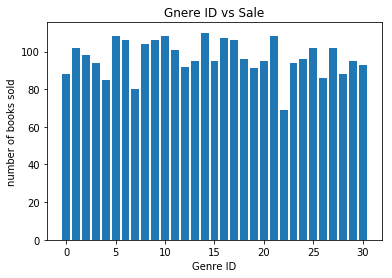

In [20]:
# plot genres of books
genre_list = list(df[bookinfo]['Book Genre'])
unique_genres, counts_genres = np.unique(genre_list, return_counts=True)
plt.bar(unique_genres, counts_genres)
plt.title("Gnere ID vs Sale")
plt.xlabel("Genre ID")
plt.ylabel("number of books sold")
plt.show()
counts_genres, unique_genres = zip(*sorted(zip(counts_genres, unique_genres)))
unique_genres_top_5 = unique_genres[:5]

In [7]:
# genre variaty per reader
reader_genre_list = []
for each_reader in df[readerinfo].index:
    bool_idx = df[bookinfo]['Book ID'].isin(Reader_read_books[each_reader])
    reader_genre_list.append(list(df[bookinfo][bool_idx]['Book Genre']))
reader_genres = [len(np.unique(reader_genre_list[i])) for i in range(num_readers)]
reader_genres = np.int32(reader_genres)

reader_genre_one_hot = np.zeros((num_readers, len(unique_genres)))
for each_user_genre_idx, each_user_genre in enumerate(reader_genre_list):
    for each_genre_idx in np.unique(each_user_genre):
        reader_genre_one_hot[each_user_genre_idx, each_genre_idx] = 1

In [8]:
# to find all word appearances and frequencies
num_books = len(df[bookinfo_words])
all_eachbook_words = []
all_eachbook_words_count = np.zeros(num_books)
for each_book_idx in df[bookinfo_words].index:
    words = df[bookinfo_words].loc[each_book_idx, 'Words in Book'].split("|")
    words = list(words)
    all_eachbook_words_count[each_book_idx] = len(words)
    all_eachbook_words.append(words)
    
word_count_df = pd.DataFrame(all_eachbook_words_count, columns=['word_counts'])
df[bookinfo_words] = pd.merge(df[bookinfo_words], word_count_df, left_index=True, right_index=True)
all_words = sum(all_eachbook_words, [])

unique_words, counts_words = np.unique(all_words, return_counts=True)
counts_words, unique_words = zip(*sorted(zip(counts_words, unique_words)))
low_freq_words = unique_words[:int(len(unique_words)*0.05)]

hard_word_freq_int_list = []
for each_book_idx in df[bookinfo_words].index:
    freq_bool_list = np.isin(low_freq_words, all_eachbook_words[each_book_idx])
    freq_int_list = np.sum(np.int16(freq_bool_list))
    hard_word_freq_int_list.append(freq_int_list)
    
hard_word_freq_int_df = pd.DataFrame(hard_word_freq_int_list, columns=['hard_word_counts'])
df[bookinfo_words] = pd.merge(df[bookinfo_words], hard_word_freq_int_df, left_index=True, right_index=True)


In [9]:
# readers read num of words
Reader_num_words = np.zeros(num_readers)
for each_reader in df[readerinfo].index:
    bool_idx = df[bookinfo_words]['Book ID'].isin(Reader_read_books[each_reader])
    Reader_num_words[each_reader] = df[bookinfo_words][bool_idx]['word_counts'].sum()
Reader_num_words = pd.DataFrame(Reader_num_words, columns=['read_word_counts'])
df[readerinfo] = pd.merge(df[readerinfo], Reader_num_words, left_index=True, right_index=True)


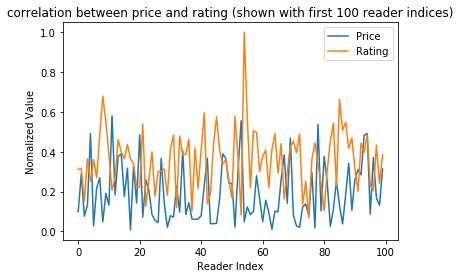

pearsonr:
(-0.00796351188407399, 0.4258784523027538)


In [22]:
# plot prices against ratings 
reader_idx = list(df[readerinfo].index)
Price_sum_list = list(df[readerinfo]['Price_sum'])
Price_sum_list = Price_sum_list / np.max(Price_sum_list)
ave_rating_list = list(df[readerinfo]['Average Rating (2017)'])
ave_rating_list = ave_rating_list / np.max(ave_rating_list)
plt.plot(reader_idx[:100], Price_sum_list[:100])
plt.plot(reader_idx[:100], ave_rating_list[:100])
plt.title("correlation between price and rating (shown with first 100 reader indices)")
plt.xlabel("Reader Index")
plt.ylabel("Nomalized Value")
plt.legend(['Price', 'Rating'])
plt.show()
price_rating_cor = stats.pearsonr(Price_sum_list, ave_rating_list)
print("pearsonr:")
print(price_rating_cor)

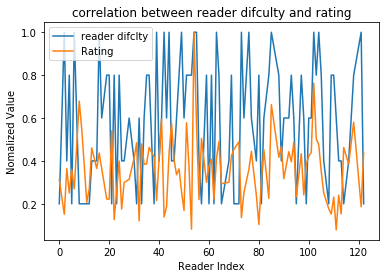

pearsonr:
(0.004061407310805554, 0.7153663872652982)


In [11]:
# plot read difficulties against ratings 
reader_idx = df[readerinfo].index
user_diffculty = df[readerinfo]['User Difficulty Choice']
user_diffculty_bool_idx = user_diffculty != "Not specified"
user_diffculty_list = np.array(user_diffculty[user_diffculty_bool_idx]).astype(np.float32)
user_diffculty_list = user_diffculty_list / np.max(user_diffculty_list)
user_diffculty_reader_idx = reader_idx[list(user_diffculty_bool_idx)]
ave_rating_list = list(df[readerinfo]['Average Rating (2017)'])
ave_rating_list = ave_rating_list / np.max(ave_rating_list)
ave_rating_user_diffculty_list = ave_rating_list[user_diffculty_bool_idx]
plt.plot(user_diffculty_reader_idx[:100], user_diffculty_list[:100])
plt.plot(user_diffculty_reader_idx[:100], ave_rating_user_diffculty_list[:100])
plt.title("correlation between reader difculty and rating")
plt.xlabel("Reader Index")
plt.ylabel("Nomalized Value")
plt.legend(["reader difclty", "Rating"])
plt.show()
difficulty_rating_cor = stats.pearsonr(user_diffculty_list, ave_rating_user_diffculty_list)
print("pearsonr:")
print(difficulty_rating_cor)

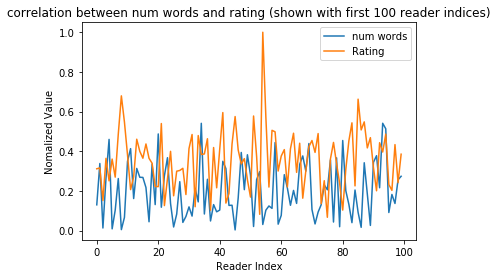

pearsonr:
(-0.004118771057252073, 0.680465962571456)


In [23]:
# plot num of words against ratings
reader_idx = df[readerinfo].index
read_word_counts = df[readerinfo]["read_word_counts"]
read_word_counts_list = read_word_counts / np.max(read_word_counts)
ave_rating_list = list(df[readerinfo]['Average Rating (2017)'])
ave_rating_list = ave_rating_list / np.max(ave_rating_list)
plt.plot(reader_idx[:100], read_word_counts_list[:100])
plt.plot(reader_idx[:100], ave_rating_list[:100])
plt.title("correlation between num words and rating (shown with first 100 reader indices)")
plt.xlabel("Reader Index")
plt.ylabel("Nomalized Value")
plt.legend(["num words", "Rating"])
plt.show()
readWords_rating_cor = stats.pearsonr(read_word_counts_list, ave_rating_list)
print("pearsonr:")
print(readWords_rating_cor)

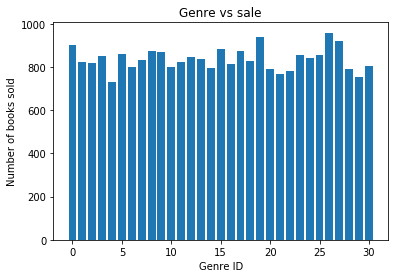

The most popular genre:
4    Series
Name: Genre Name, dtype: object
The least popular genre:
10    Romance
Name: Genre Name, dtype: object


In [24]:
# genre sale
Reader_book_genre = []
for each_reader in df[readerinfo].index:
    bool_idx = df[bookinfo]['Book ID'].isin(Reader_read_books[each_reader])
    Reader_book_genre.append(list(df[bookinfo][bool_idx]['Book Genre']))
Reader_book_genre_all = sum(Reader_book_genre, [])
unique_Reader_book_genre, counts_Reader_book_genre = np.unique(Reader_book_genre_all, return_counts=True)
plt.bar(unique_Reader_book_genre, counts_Reader_book_genre)
plt.title("Genre vs sale")
plt.xlabel("Genre ID")
plt.ylabel("Number of books sold")
plt.show()
max_genre_counts = np.max(counts_Reader_book_genre)
argmax_genre_counts = np.argmax(counts_Reader_book_genre)
min_genre_counts = np.min(counts_Reader_book_genre)
argmin_genre_counts = np.argmin(counts_Reader_book_genre)
print("The most popular genre:")
print(df[bookinfo_genre][df[bookinfo_genre]['Genre ID'] == argmax_genre_counts]['Genre Name'])
print("The least popular genre:")
print(df[bookinfo_genre][df[bookinfo_genre]['Genre ID'] == argmin_genre_counts]['Genre Name'])


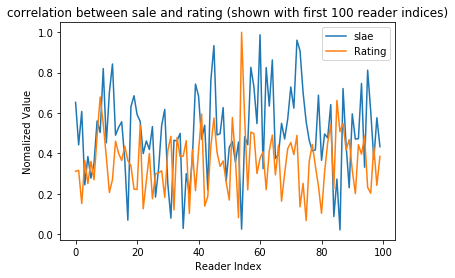

pearsonr:
(0.005308372667705444, 0.5955749505085446)


In [25]:
# plot sale against rating
# book sale and ratings were normalized; 
# sale is defined as each_user_purchased_book_sum(book_sale_num) / num_each_user_purchased_books
book_sale_per_user = np.zeros(num_readers)
df[bookinfo]['Number_Sold_Norma'] = df[bookinfo]['Number Sold'] / df[bookinfo]['Number Sold'].max()
for each_reader in df[readerinfo].index:
    bool_idx = df[bookinfo]['Book ID'].isin(Reader_read_books[each_reader])
    book_sale_per_user[each_reader] = df[bookinfo][bool_idx]['Number_Sold_Norma'].sum() / len(df[bookinfo][bool_idx]['Number_Sold_Norma'])
ave_rating_list = list(df[readerinfo]['Average Rating (2017)'])
ave_rating_list = ave_rating_list / np.max(ave_rating_list)
plt.plot(reader_idx[:100], book_sale_per_user[:100])
plt.plot(reader_idx[:100], ave_rating_list[:100])
plt.title("correlation between sale and rating (shown with first 100 reader indices)")
plt.xlabel("Reader Index")
plt.ylabel("Nomalized Value")
plt.legend(["slae", "Rating"])
plt.show()
sale_rating_cor = stats.pearsonr(book_sale_per_user, ave_rating_list)
print("pearsonr:")
print(sale_rating_cor)

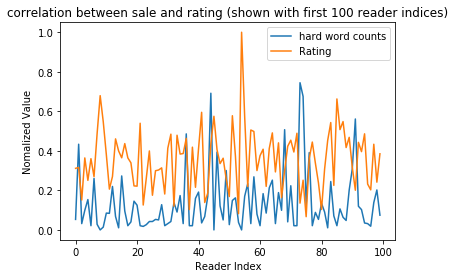

pearsonr:
(0.008640726138020517, 0.38759847878729337)


In [26]:
# plot hard words against rating
hard_word_counts_per_user = np.zeros(num_readers)
for each_reader in df[readerinfo].index:
    bool_idx = df[bookinfo]['Book ID'].isin(Reader_read_books[each_reader])
    hard_word_counts_per_user[each_reader] = df[bookinfo_words][bool_idx]['hard_word_counts'].sum() / len(df[bookinfo_words][bool_idx]['hard_word_counts'])
hard_word_counts_per_user = hard_word_counts_per_user / np.max(hard_word_counts_per_user)
ave_rating_list = list(df[readerinfo]['Average Rating (2017)'])
ave_rating_list = ave_rating_list / np.max(ave_rating_list)
plt.plot(reader_idx[:100], hard_word_counts_per_user[:100])
plt.plot(reader_idx[:100], ave_rating_list[:100])
plt.title("correlation between sale and rating (shown with first 100 reader indices)")
plt.xlabel("Reader Index")
plt.ylabel("Nomalized Value")
plt.legend(["hard word counts", "Rating"])
plt.show()
hard_words_rating_cor = stats.pearsonr(hard_word_counts_per_user, ave_rating_list)
print("pearsonr:")
print(hard_words_rating_cor)

### Feature Space Conclusion

All significant features were explored but there is no evident relationships between features of books and readers, and ratings. There is no observation that prices of books, genres of books, difficulties of reading, book store locations have significant impacts on ratings.

In [16]:
# generate feature space
Feature_space = df[readerinfo]
col_name_list = Feature_space.columns

label = Feature_space['Average Rating (2017)'].astype(np.int16)
Feature_space = Feature_space.drop(['Average Rating (2017)'], axis=1)

read_difficulty_feat = list(Feature_space['User Difficulty Choice'])
read_difficulty_feat = np.int64(['3' if x == 'Not specified' else x for x in read_difficulty_feat])
Feature_space['User Difficulty Choice'] = read_difficulty_feat
Feature_space['sale'] = ave_rating_list
Feature_space['hard_word_counts'] = df[bookinfo_words]['hard_word_counts']
Feature_space['reader_visited_stores'] = reader_visited_stores
Feature_space['reader_genres'] = reader_genres

# to add some non-linearity
Feature_space['hard_word_counts_sq'] = Feature_space['hard_word_counts'] ** 2 
Feature_space['User Difficulty Choice sq'] = Feature_space['User Difficulty Choice'] ** 2
Feature_space['sale'] = Feature_space['sale'] ** 2
Feature_space['sale'] = Feature_space['sale'] ** 1.5
Feature_space['sale'] = Feature_space['sale'] ** 0.5

reader_visited_stores_one_hot_dataframe = pd.DataFrame(reader_visited_stores_one_hot)
Feature_space = pd.merge(Feature_space, reader_visited_stores_one_hot_dataframe, left_index=True, right_index=True)

reader_genre_one_hot_dataframe = pd.DataFrame(reader_genre_one_hot)
Feature_space = pd.merge(Feature_space, reader_genre_one_hot_dataframe, left_index=True, right_index=True)

Feature_space = Feature_space.drop(['User ID'], axis=1)
Feature_space = Feature_space.drop(['User Read Books (2017)'], axis=1)
Feature_space = Feature_space.drop(['User Read Books (2018)'], axis=1)

Feature_space = Feature_space.fillna(0)

x = Feature_space.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
Feature_space = pd.DataFrame(x_scaled)


In [17]:
Feature_space_train, Feature_space_test, Label_train, Label_test = train_test_split(Feature_space, label, test_size=0.1851)

DT_clf = tree.DecisionTreeRegressor()
DT_clf = DT_clf.fit(Feature_space_train, Label_train)
pred_DT_train = DT_clf.predict(Feature_space_train)
Result_DT_train_mse = mean_squared_error(pred_DT_train, Label_train)
pred_DT_test = DT_clf.predict(Feature_space_test)
Result_DT_mse = mean_squared_error(pred_DT_test, Label_test)
print("Result_DT_mse: " + str(Result_DT_mse))

RF_clf = RandomForestRegressor()
RF_clf = RF_clf.fit(Feature_space_train, Label_train)
pred_RF_train = RF_clf.predict(Feature_space_train)
Result_RF_train_mse = mean_squared_error(pred_RF_train, Label_train)
pred_RF_test = RF_clf.predict(Feature_space_test)
Result_RF_mse = mean_squared_error(pred_RF_test, Label_test)
print("Result_RF_mse: " + str(Result_RF_mse))

# xgboost
xgb_clf = XGBClassifier()
xgb_clf.fit(Feature_space_train, Label_train)
pred_xgb_test = xgb_clf.predict(Feature_space_test)
Result_xgb_mse = mean_squared_error(pred_xgb_test, Label_test)
print("Result_xgb_mse: " + str(Result_xgb_mse))

# nn
nn_model = Sequential()
nn_model.add(Dense(90, input_dim=Feature_space.shape[1], activation='relu'))
nn_model.add(Dense(30, activation='relu'))
nn_model.add(Dense(10, activation='relu'))
nn_model.add(Dense(1, activation='linear'))

nn_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_squared_error'])

nn_model.fit(Feature_space_train, Label_train, epochs=50, batch_size=15)

scores = nn_model.evaluate(Feature_space_test, Label_test)
print("nn: " + str(scores))

Result_DT_mse: 0.0
Result_RF_mse: 0.00019989195029713645


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Result_xgb_mse: 0.0
Epoch 1/50
8149/8149 [==============================] - 1s 156us/step - loss: 1.3027 - mean_squared_error: 1.3027
Epoch 2/50
8149/8149 [==============================] - 1s 127us/step - loss: 0.1688 - mean_squared_error: 0.1688
Epoch 3/50
8149/8149 [==============================] - 1s 135us/step - loss: 0.1323 - mean_squared_error: 0.1323
Epoch 4/50
8149/8149 [==============================] - 1s 126us/step - loss: 0.1191 - mean_squared_error: 0.1191
Epoch 5/50
8149/8149 [==============================] - 1s 121us/step - loss: 0.1111 - mean_squared_error: 0.1111
Epoch 6/50
8149/8149 [==============================] - 1s 126us/step - loss: 0.1091 - mean_squared_error: 0.1091
Epoch 7/50
8149/8149 [==============================] - 1s 130us/step - loss: 0.1041 - mean_squared_error: 0.1041
Epoch 8/50
8149/8149 [==============================] - 1s 122us/step - loss: 0.1004 - mean_squared_error: 0.1004
Epoch 9/50
8149/8149 [==============================] - 1s 122us/ste

In [18]:
# result generate; regard 2017 ratings as the labels with aforementioned features for input
selected_pred_result = DT_clf.predict(Feature_space)
selected_pred_result = np.around(selected_pred_result)
selected_pred_result[selected_pred_result >= 8] -= 1.5
selected_pred_result[selected_pred_result >= 7] -= 1
selected_pred_result[selected_pred_result <= 2] += 1.5
selected_pred_result[selected_pred_result <= 3] += 1

# take books read in 2017 with average ratings of readers
book_ratings = pd.DataFrame(data=np.zeros((num_books, 2)), columns=['sum_rating', 'num_rating'])
book_ratings['Book ID'] = df[bookinfo]['Book ID']
book_ratings = book_ratings.set_index('Book ID')
for each_reader in df[readerinfo].index:
    bool_idx = df[bookinfo]['Book ID'].isin(Reader_read_books[each_reader])
    for each_book_id in df[bookinfo][bool_idx]['Book ID']:
        book_ratings.loc[each_book_id, 'sum_rating'] += df[readerinfo].loc[each_reader, 'Average Rating (2017)']
        book_ratings.loc[each_book_id, 'num_rating'] += 1
book_ratings['Book_Ave_Rating'] = book_ratings['sum_rating'] / book_ratings['num_rating']
reader_2018rating = np.zeros(num_readers).reshape(num_readers, 1)
for each_reader in df[readerinfo].index:
    book_list_str = df[readerinfo].loc[each_reader, 'User Read Books (2018)']
    book_list = np.int32(book_list_str.split(', '))
    book_len = len(book_list)
    book_rating_list = [book_ratings.loc[each_book_id, 'Book_Ave_Rating'] for each_book_id in book_list]
    reader_2018rating[each_reader, 0] = np.sum(book_rating_list) / book_len

# selected_pred_result can be that from model or dirrectly from 2017 rating
use_label_as_the_base = False
if use_label_as_the_base:
    selected_pred_result = label.values.astype(np.float64)
    selected_pred_result[selected_pred_result >= 7] -= 1
    selected_pred_result[selected_pred_result <= 3] += 1
    selected_pred_result = selected_pred_result.reshape(num_readers, 1)

final_pred_result = selected_pred_result
two_yr_gap = (reader_2018rating - selected_pred_result)

Final_df = pd.DataFrame({'model_pred':np.ravel(np.float64(selected_pred_result)), 'bookrt_pred':np.ravel(reader_2018rating)})
Final_df['result'] = np.float64(Final_df['model_pred'])
Final_df['gap'] = Final_df['bookrt_pred'] - Final_df['model_pred']
gap_action = 3
discount_action = 0.5
for each_user_idx in Final_df.index:
    if Final_df.loc[each_user_idx, 'gap'] > gap_action:
        Final_df.loc[each_user_idx, 'result'] += Final_df.loc[each_user_idx, 'gap'] * discount_action
    if Final_df.loc[each_user_idx, 'gap'] < -gap_action:
        Final_df.loc[each_user_idx, 'result'] += Final_df.loc[each_user_idx, 'gap'] * discount_action

final_result = np.around(Final_df['result'])

final_sub = pd.DataFrame(df[readerinfo]['User ID'], columns=['User ID'])
final_sub['Average Rating (2018)'] = final_result

final_sub.to_csv('submission.csv', header=True, index=False)